## Augmentation options

### In time domain
- Pitch Shifting
- Loudness (static and dynamic)
- Additive Gaussian Noise
- Time Stretching

### In frequency domain (changes timbre and was thus not considered in that work)
- Time Warping
- Frequency and Time Masking
- Frequency Filtering

In [26]:

# import pyrubberband
import augmentation
import librosa
import librosa.display
from scipy import interpolate
import ipywidgets as widgets
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np
import random

import pyrubberband

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Functions by C&M class

def multiplay(clips, sf, title=None):
    outs = [widgets.Output() for c in clips]
    for ix, item in enumerate(clips):
        with outs[ix]:
            print(title[ix] if title is not None else "")
            display(Audio(item, rate=sf, normalize=True))
    return widgets.HBox(outs)


def tapering_window(N, overlap):
    R = int(N * overlap / 2)
    r = np.arange(0, R) / float(R)
    win = np.r_[r, np.ones(N - 2*R), r[::-1]]
    stride = N - R - 1 if R > 0 else N
    return win, stride


def pitchshift_gs_rt(x, alpha, grain_size, overlap=0.4):
    win, stride = tapering_window(grain_size, overlap)
    # resampling needs these many input samples to produce an output grain of the chosen size
    chunk_size = int(np.floor(grain_size + 1) * alpha)
    y = np.zeros(len(x))
    # input chunks and output grains are always aligned in pitch shifting (in_hop = out_hop = stride)
    for n in range(0, len(x) - max(chunk_size, grain_size), stride):
        y[n:n+grain_size] += resample(x[n:n+chunk_size], 1 / alpha) * win
    return y


semitone = 2 ** (1.0 / 12)


def ms2n(ms, sf):
    return int(float(sf) * float(ms) / 1000.0)


def resample(x, alpha):
    # length of the output signal after resampling
    n_out = int(np.floor(len(x) * alpha))
    y = np.zeros(n_out)
    for iy in range(0, n_out - 1):
        t = iy / alpha
        ix = int(t)
        y[iy] = (1 - (t - ix)) * x[ix] + (t - ix) * x[ix + 1]
    return y


/home/nicolas/workspace/ma/ma4/ddspzart/.venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


22050

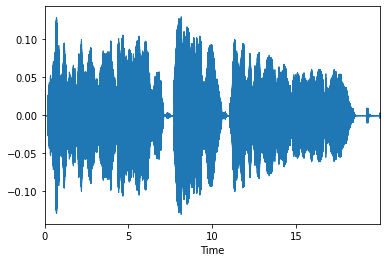

In [28]:
link = "AlleMeineEntchen.m4a"
Audio(filename=link)

DUR = 20

x, sr = librosa.load(link, offset=2, duration=DUR)
SF = sr
plt.figure()
librosa.display.waveplot(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
sr


In [29]:
PST = augmentation.PitchShiftTransformer(sample_rate=sr, shift_semitones=-2)
y = PST(x)

TST = augmentation.TimeStretchingTransformer(sample_rate=sr, stretch_factor=2)
y2 = TST(x)

time_map = [(0, 0), (sr, sr), (3*sr, 2*sr), (6*sr, 4*sr), (len(x), len(x))]
y3 = pyrubberband.pyrb.timemap_stretch(x, sr, time_map)


(441000,) (220500,)


In [30]:
multiplay([x, y, y2, y3], sr, title=["x", "y", "y2", "y3"])


In [31]:
# All
PST = augmentation.PitchShiftAugmentationTransformer(max_shift=4)
TST = augmentation.TimeStretchingAugmentationTransformer(
    sample_rate=sr, min_stretch_factor=0.5, max_stretch_factor=2)
LAT = augmentation.LoudnessAugmentationTransformer(f_max=2)
AWGN = augmentation.AdditiveGaussianNoiseAugmentationTransformer(
    sigma_max=0.005)
DLAT = augmentation.DiverseLoudnessAugmentationTransformer(f_max=3, Tc=1.)

pipeline = [PST, LAT, DLAT, AWGN, TST]

x_mod = []
for p in pipeline:
    print(p)
    x_mod.append(p(x))

multiplay([x, x_mod[0], x_mod[1], x_mod[2], x_mod[3], x_mod[4]], sr,
          title=['ORIGINAL', 'PST', 'LAT', 'DLAT', 'AWGN', 'TST'])


PitchShiftAugmentationTransformer(name='pitch_shift-(16000-4)')
LoudnessAugmentationTransformer(name='loudness_augmentation_2')
DiverseLoudnessAugmentationTransformer(name='diverse_loudness_3')
AdditiveGaussianNoiseAugmentationTransformer(name='additive_gaussian_noise_augmentation_0_0.005')
TimeStretchingAugmentationTransformer(name='time_stretching_2')


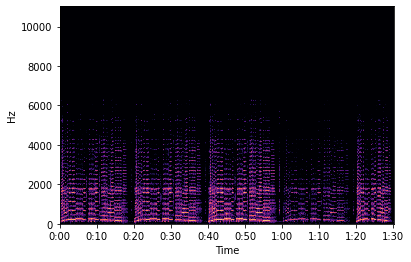

In [32]:
x_augmented = np.concatenate(
    (x, x_mod[0], x_mod[1], x_mod[2], x_mod[4]), axis=0)

X_aug = librosa.stft(PST(x_augmented))
X_aug_dB = librosa.amplitude_to_db(abs(X_aug))

librosa.display.specshow(X_aug_dB, sr=sr, x_axis='time', y_axis='hz')
plt.show()

multiplay([x_augmented], sr, title=['PST', 'LAT', 'AWGN'])


In [33]:
# Get augmented signal
Tsplit = 4
Nsplit = len(x) / (Tsplit * sr)

augmentation_policy = ["PitchShiftAugmentationTransformer", "DiverseLoudnessAugmentationTransformer",
                       "TimeStretchingTransformer"]  # "LoudnessAugmentationTransformer",

PST = augmentation.PitchShiftAugmentationTransformer(max_shift=4)
TST = augmentation.TimeStretchingAugmentationTransformer(
    sample_rate=sr, min_stretch_factor=0.5, max_stretch_factor=2)
LAT = augmentation.LoudnessAugmentationTransformer(f_max=2)
AWGN = augmentation.AdditiveGaussianNoiseAugmentationTransformer(
    sigma_max=0.005)
DLAT = augmentation.DiverseLoudnessAugmentationTransformer(f_max=3, Tc=1.)

augmentation_policies = dict(zip(augmentation_policy, [PST, DLAT, TST]))


In [34]:
splits = np.array_split(x, Nsplit)
N_iter = 1
for i_s in range(len(splits)):
    x_s = splits[i_s]
    for i in range(N_iter):
        for aug_policy in augmentation_policies.values():
            x_s = aug_policy(x_s)
        splits.append(x_s)
random.shuffle(splits)


In [35]:
x_aug = np.concatenate(splits)
multiplay([x_aug], sr, title=["Augmented audio."])
